In [1]:
client.close()

NameError: name 'client' is not defined

In [2]:
%matplotlib inline

import hipscat
import hipscat_import
import pandas as pd
import multiprocessing as mp
import glob
from tqdm import tqdm
import os.path
import numpy as np
import healpy as hp
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from dask.distributed import Client

import importlib

import sys
sys.path.append('../src/')  # Replace '/path/to/my_functions'

pd.set_option('display.max_columns', None)

In [3]:
try: 
    client.close()
except:
    pass

client = Client(n_workers=48*2, threads_per_worker=1, memory_limit="16GB") # "auto")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 96
Total threads: 96,Total memory: 1.40 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33487,Workers: 96
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 1.40 TiB
Comm: tcp://127.0.0.1:46443,Total threads: 1
Dashboard: http://127.0.0.1:33141/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:33543,


In [4]:
trilFn = "/home/lovro/scratch/data/TRILEGAL_hipscat_new_2/trilegal/"
fo = "/home/lovro/scratch/data/TRILEGAL_hipscat_new_2/trilegal/photod_testing/makeSimcatCatalog"

tril = lsdb.read_hipscat(trilFn, columns=['ra', 'dec', 
                                         'umag', 'gmag', 'rmag', 'imag', 'zmag',
                                        'm_h', 'gc', 'label', 'mu0', 'av'], 
                         search_filter=ConeSearch(ra=-60, dec=20, radius_arcsec=10*3600))

tril.head()

,ra,dec,umag,gmag,rmag,imag,zmag,m_h,gc,label,mu0,av
_hipscat_index,,,,,,,,,,,,
3611916510617927680,300.973383,12.355981,26.415001,23.885000,22.771999,22.320000,22.080000,-0.47,2,1,15.15,0.605
3611916514187280384,300.968174,12.354759,30.388000,27.014000,25.503000,23.752001,22.931999,-0.06,1,1,12.10,0.599
3611916514711568384,300.967884,12.355377,30.372999,27.358999,25.827000,24.823999,24.308001,-0.58,2,1,14.70,0.461
3611916514719956992,300.967635,12.355393,31.802999,28.617001,27.000999,25.847000,25.264000,-0.70,2,1,14.70,0.413
3611916515617538048,300.970129,12.355299,21.277000,19.785000,19.186001,18.976000,18.879000,-0.06,1,1,14.05,0.487


In [5]:
tril.head(1000).to_csv("../../temp/hipscat_test.csv")

OSError: Cannot save file into a non-existent directory: '../../temp'

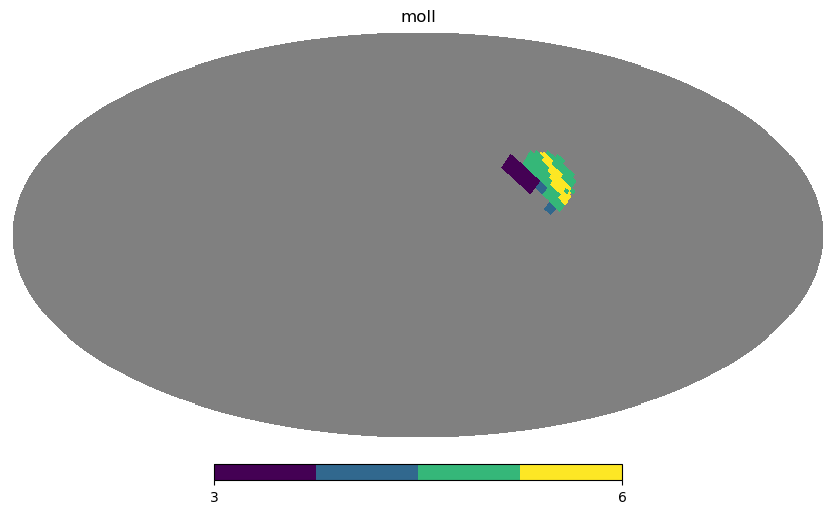

In [9]:
tril.plot_pixels('moll')
# tril.skymap(lambda df, a: np.log(len(df)+1), order=9)

In [10]:
import LocusTools as lt
# import makeSimPhotometryLSDB
# importlib.reload(makeSimPhotometryLSDB)
import makeSimPhotometry
importlib.reload(makeSimPhotometry)
importlib.reload(lt)

MSRGlocus = "../data/LocusData/SDSSDSEDlocus_10Gyr.txt"
WDlocusH  = "../data/LocusData/WD_Hydrogen_MrColorSequences.txt"
WDlocusHe = "../data/LocusData/WD_Helium_MrColorSequences.txt"

# trilFn = "/home/lovro/scratch/data/TRILEGAL_hipscat/trilegal/"
trilFn = "/home/lovro/scratch/data/TRILEGAL_hipscat_new_2/trilegal/"
fo = "/home/lovro/scratch/data/TRILEGAL_hipscat_new_2/trilegal/photod_testing"

tril = lsdb.read_hipscat(trilFn, columns=['ra', 'dec', 
                                         'umag', 'gmag', 'rmag', 'imag', 'zmag',
                                        'm_h', 'gc', 'label', 'mu0', 'av'], 
                         search_filter=ConeSearch(ra=-60, dec=20, radius_arcsec=50*3600))

# lsdb.catalog.Catalog.map_partitions(tril, makeSimPhotometryLSDB.makeSimLSSTcatFromTRILEGAL)


def calc_Mr(df):
    # calculate absmag in the r band based on the catalog value of the true distance modulus (m0) and return it.
    return df["mu0"]-df["rmag"]

def calc_Ar(df):
    # calculate Ar and return it. 
    return 2.75 * df['av'] / 3.10  

def zi_col_names(df):
    # Convert TRILEGAL column names to Željko's notation and add Ar
    df = df.rename(columns={'m_h': 'FeH', 'gc': 'GC', 'label': 'pop'})
    # df['Ar'] = 2.75 * df['av'] / 3.10  
    return df

def foo(cat):
    cat = zi_col_names(cat)
    cat['Mr'] = calc_Mr(cat)
    cat['Ar'] = calc_Ar(cat)
    return cat;


tril = lsdb.catalog.Catalog.map_partitions(tril, foo)

# tril = lsdb.catalog.Catalog.map_partitions(tril, makeSimPhotometryLSDB.makeSimLSSTcatFromTRILEGAL)
# tril = lsdb.catalog.Catalog.map_partitions(tril, makeSimPhotometry.makeSimLSSTcatFromTRILEGAL)

In [15]:
tril.head(1000).to_csv("../../temp/hipscat_test.csv")

In [ ]:
tril.map_ca

In [14]:
r = lsdb.catalog.Catalog.map_partitions(tril, makeSimPhotometryLSDB.makeSimLSSTcatFromTRILEGAL)
r.head()

NameError: name 'makeSimPhotometryLSDB' is not defined

In [ ]:
/mnt/beegfs/scratch/PhotoD/notebooks/../src/LocusTools.py:1091: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lvalues.loc[:, 'MrAssigned'] = 0*Lvalues['Mr']-9.99
/mnt/beegfs/scratch/PhotoD/notebooks/../src/LocusTools.py:1093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [20]:
lsdb.catalog.Catalog.map_partitions?

Signature:
lsdb.catalog.Catalog.map_partitions(
    self,
    func: 'Callable[..., pd.DataFrame]',
    *args,
    meta: 'pd.DataFrame | pd.Series | Dict | Iterable | Tuple | None' = None,
    include_pixel: 'bool' = False,
    **kwargs,
) -> 'Self'
Docstring:
Applies a function to each partition in the catalog.

The ra and dec of each row is assumed to remain unchanged.

Args:
    func (Callable): The function applied to each partition, which will be called with:
        `func(partition: pd.DataFrame, *args, **kwargs)` with the additional args and kwargs passed to
        the `map_partitions` function. If the `include_pixel` parameter is set, the function will be
        called with the `healpix_pixel` as the second positional argument set to the healpix pixel
        of the partition as
        `func(partition: pd.DataFrame, healpix_pixel: HealpixPixel, *args, **kwargs)`
    *args: Additional positional arguments to call `func` with.
    meta (pd.DataFrame | pd.Series | Dict | Iterabl

# Testing

In [16]:
import pandas as pd
import numpy as np

# Define the size of the DataFrame
num_rows = 10  # Number of rows
num_cols = 5   # Number of columns

# Create random data
data = np.random.rand(num_rows, num_cols)

# Create a DataFrame
df = pd.DataFrame(data, columns=[f"col_{i+1}" for i in range(num_cols)])

# Print the DataFrame
print(df)

      col_1     col_2     col_3     col_4     col_5
0  0.837208  0.196002  0.464623  0.198718  0.370091
1  0.466170  0.546453  0.900692  0.395945  0.802363
2  0.439856  0.090553  0.288629  0.235536  0.262710
3  0.954347  0.106937  0.053539  0.551308  0.451266
4  0.722960  0.280197  0.592965  0.732628  0.538376
5  0.183817  0.377917  0.206026  0.445990  0.018116
6  0.088910  0.389564  0.438082  0.000519  0.094592
7  0.603920  0.983978  0.405030  0.544515  0.849402
8  0.472190  0.216441  0.935974  0.300059  0.847780
9  0.150058  0.404904  0.760083  0.987725  0.944993


In [17]:
df.loc[:, "a"]=0*df['col_1']-9.99
df

,col_1,col_2,col_3,col_4,col_5,a
0,0.837208,0.196002,0.464623,0.198718,0.370091,-9.99
1,0.466170,0.546453,0.900692,0.395945,0.802363,-9.99
2,0.439856,0.090553,0.288629,0.235536,0.262710,-9.99
3,0.954347,0.106937,0.053539,0.551308,0.451266,-9.99
4,0.722960,0.280197,0.592965,0.732628,0.538376,-9.99
5,0.183817,0.377917,0.206026,0.445990,0.018116,-9.99
6,0.088910,0.389564,0.438082,0.000519,0.094592,-9.99
7,0.603920,0.983978,0.405030,0.544515,0.849402,-9.99
8,0.472190,0.216441,0.935974,0.300059,0.847780,-9.99
9,0.150058,0.404904,0.760083,0.987725,0.944993,-9.99


In [ ]:
def foo(df):
    df = pd.DataFrame(df)
    print(type(df))
    return 2

def map_partitions(self, func, *args, **kwargs):
    ddf = self._ddf.map_partitions(func, *args, **kwargs)
    return lsdb.Catalog(ddf, self._ddf_pixel_map, self.hc_structure)

# map_partitions(tril, foo)
# tril.head()

# tril = tril.assign(ret = makeSimPhotometryLSDB.makeSimLSSTcatFromTRILEGAL)
tril = map_partitions(tril, makeSimPhotometryLSDB.makeSimLSSTcatFromTRILEGAL)


    
# tril.to_hipscat("/home/lovro/scratch/data/TRILEGAL_hipscat/trilegal/photod_testing", 
#                overwrite=True)
# h = tril.skymap(lambda df, a: np.log(len(df)+1), order=9)

In [11]:
3611917281933656064==3611917281933656064

True

In [15]:
import dask.dataframe as dd
import pandas as pd
import numpy as np

# Generate synthetic data for DataFrame 1
data1 = {'A': np.arange(0, 10**6),
         'B': np.arange(-1*10**6, 0),
        }
df1 = pd.DataFrame(data1)

# Convert Pandas DataFrame to Dask DataFrame
Lvalues = dd.from_pandas(df1, npartitions=2)  # Assuming 2 partitions

# Generate synthetic data for DataFrame 2
data2 = {'X': np.linspace(10, 100, 10),
         'Y': np.linspace(10, 100, 10),
         'Z': np.random.choice(['A', 'B', 'C'], 10)}
df2 = pd.DataFrame(data2)

# Convert Pandas DataFrame to Dask DataFrame
L = dd.from_pandas(df2, npartitions=2)  # Assuming 2 partitions

# Display Dask DataFrames
print("Dask Lvalues:")
print(Lvalues.head())
print("\nDask L:")
print(L.head())

Dask Lvalues:
   A     B         C         D         E
0  0 -1000  0.526936  0.890150  0.300008
1  1  -999  0.981754  0.577600  0.527688
2  2  -998  0.254885  0.467504  0.791801
3  3  -997  0.170918  0.837107  0.258398
4  4  -996  0.832516  0.795530  0.431980

Dask L:
      X     Y  Z
0  10.0  10.0  B
1  20.0  20.0  A
2  30.0  30.0  B
3  40.0  40.0  B
4  50.0  50.0  A


In [36]:
LX = L['X'].compute().to_numpy()
LY = L['Y'].compute().to_numpy()
LvaluesA = Lvalues['A'].compute().to_numpy()
LvaluesB = Lvalues['B'].compute().to_numpy()

In [41]:
#distSq = ((LX[:, np.newaxis] - LvaluesA)**2) / (0.01**2) #+ ((LY[:, np.newaxis] - LvaluesB)**2) / (0.1**2)
distSq = ((LX[:, np.newaxis] - LvaluesA))
pd.DataFrame(distSq)

0     1     2     3     4     5     6     7     8     9     10    11   \
0   10.0   9.0   8.0   7.0   6.0   5.0   4.0   3.0   2.0   1.0   0.0  -1.0   
1   20.0  19.0  18.0  17.0  16.0  15.0  14.0  13.0  12.0  11.0  10.0   9.0   
2   30.0  29.0  28.0  27.0  26.0  25.0  24.0  23.0  22.0  21.0  20.0  19.0   
3   40.0  39.0  38.0  37.0  36.0  35.0  34.0  33.0  32.0  31.0  30.0  29.0   
4   50.0  49.0  48.0  47.0  46.0  45.0  44.0  43.0  42.0  41.0  40.0  39.0   
5   60.0  59.0  58.0  57.0  56.0  55.0  54.0  53.0  52.0  51.0  50.0  49.0   
6   70.0  69.0  68.0  67.0  66.0  65.0  64.0  63.0  62.0  61.0  60.0  59.0   
7   80.0  79.0  78.0  77.0  76.0  75.0  74.0  73.0  72.0  71.0  70.0  69.0   
8   90.0  89.0  88.0  87.0  86.0  85.0  84.0  83.0  82.0  81.0  80.0  79.0   
9  100.0  99.0  98.0  97.0  96.0  95.0  94.0  93.0  92.0  91.0  90.0  89.0   

    12    13    14    15    16    17    18    19    20    21    22    23   \
0  -2.0  -3.0  -4.0  -5.0  -6.0  -7.0  -8.0  -9.0 -10.0 -11.0 -12.0 -13.0   
1   8.0   7.0   6.0   5.0   4.0   3.0   2.0   1.0   0.0  -1.0  -2.0  -3.0   
2  18.0  17.0  16.0  15.0  14.0  13.0  12.0  11.0  10.0   9.0   8.0   7.0   
3  28.0  27.0  26.0  25.0  24.0  23.0  22.0  21.0  20.0  19.0  18.0  17.0   
4  38.0  37.0  36.0  35.0  34.0  33.0  32.0  31.0  30.0  29.0  28.0  27.0   
5  48.0  47.0  46.0  45.0  44.0  43.0  42.0  41.0  40.0  39.0  38.0  37.0   
6  58.0  57.0  56.0  55.0  54.0  53.0  52.0  51.0  50.0  49.0  48.0  47.0   
7  68.0  67.0  66.0  65.0  64.0  63.0  62.0  61.0  60.0  59.0  58.0  57.0   
8  78.0  77.0  76.0  75.0  74.0  73.0  72.0  71.0  70.0  69.0  68.0  67.0   
9  88.0  87.0  86.0  85.0  84.0  83.0  82.0  81.0  80.0  79.0  78.0  77.0   

    24    25    26    27    28    29    30    31    32    33    34    35   \
0 -14.0 -15.0 -16.0 -17.0 -18.0 -19.0 -20.0 -21.0 -22.0 -23.0 -24.0 -25.0   
1  -4.0  -5.0  -6.0  -7.0  -8.0  -9.0 -10.0 -11.0 -12.0 -13.0 -14.0 -15.0   
2   6.0   5.0   4.0   3.0   2.0   1.0   0.0  -1.0  -2.0  -3.0  -4.0  -5.0   
3  16.0  15.0  14.0  13.0  12.0  11.0  10.0   9.0   8.0   7.0   6.0   5.0   
4  26.0  25.0  24.0  23.0  22.0  21.0  20.0  19.0  18.0  17.0  16.0  15.0   
5  36.0  35.0  34.0  33.0  32.0  31.0  30.0  29.0  28.0  27.0  26.0  25.0   
6  46.0  45.0  44.0  43.0  42.0  41.0  40.0  39.0  38.0  37.0  36.0  35.0   
7  56.0  55.0  54.0  53.0  52.0  51.0  50.0  49.0  48.0  47.0  46.0  45.0   
8  66.0  65.0  64.0  63.0  62.0  61.0  60.0  59.0  58.0  57.0  56.0  55.0   
9  76.0  75.0  74.0  73.0  72.0  71.0  70.0  69.0  68.0  67.0  66.0  65.0   

    36    37    38    39    40    41    42    43    44    45    46    47   \
0 -26.0 -27.0 -28.0 -29.0 -30.0 -31.0 -32.0 -33.0 -34.0 -35.0 -36.0 -37.0   
1 -16.0 -17.0 -18.0 -19.0 -20.0 -21.0 -22.0 -23.0 -24.0 -25.0 -26.0 -27.0   
2  -6.0  -7.0  -8.0  -9.0 -10.0 -11.0 -12.0 -13.0 -14.0 -15.0 -16.0 -17.0   
3   4.0   3.0   2.0   1.0   0.0  -1.0  -2.0  -3.0  -4.0  -5.0  -6.0  -7.0   
4  14.0  13.0  12.0  11.0  10.0   9.0   8.0   7.0   6.0   5.0   4.0   3.0   
5  24.0  23.0  22.0  21.0  20.0  19.0  18.0  17.0  16.0  15.0  14.0  13.0   
6  34.0  33.0  32.0  31.0  30.0  29.0  28.0  27.0  26.0  25.0  24.0  23.0   
7  44.0  43.0  42.0  41.0  40.0  39.0  38.0  37.0  36.0  35.0  34.0  33.0   
8  54.0  53.0  52.0  51.0  50.0  49.0  48.0  47.0  46.0  45.0  44.0  43.0   
9  64.0  63.0  62.0  61.0  60.0  59.0  58.0  57.0  56.0  55.0  54.0  53.0   

    48    49    50    51    52    53    54    55    56    57    58    59   \
0 -38.0 -39.0 -40.0 -41.0 -42.0 -43.0 -44.0 -45.0 -46.0 -47.0 -48.0 -49.0   
1 -28.0 -29.0 -30.0 -31.0 -32.0 -33.0 -34.0 -35.0 -36.0 -37.0 -38.0 -39.0   
2 -18.0 -19.0 -20.0 -21.0 -22.0 -23.0 -24.0 -25.0 -26.0 -27.0 -28.0 -29.0   
3  -8.0  -9.0 -10.0 -11.0 -12.0 -13.0 -14.0 -15.0 -16.0 -17.0 -18.0 -19.0   
4   2.0   1.0   0.0  -1.0  -2.0  -3.0  -4.0  -5.0  -6.0  -7.0  -8.0  -9.0   
5  12.0  11.0  10.0   9.0   8.0   7.0   6.0   5.0   4.0   3.0   2.0   1.0   
6  22.0  21.0  20.0  19.0  18.0  17.0  16.0  15.0  14.0  13.0  

In [46]:
np.argmin(distSq, axis=0).shape

(1000,)

In [13]:
distSq = ((L['X'][:, np.newaxis] - Lvalues['A'])**2) / (0.01**2) + ((L['B'][:, np.newaxis] - Lvalues['Y'])**2) / (0.1**2)

IndexingError: Too many indexers

In [13]:
# Create a Cartesian product of A and B to combine every row of A with every row of B
cartesian_product = dd.merge(df1.assign(key=1), df2.assign(key=1), on='key').drop('key', axis=1)

# Perform the subtraction using vectorized operations
result = cartesian_product.map_partitions(lambda df: df1['B'] - df2['Y'], meta=('float64'))

# Note: Replace 'A_column' and 'B_column' with the actual column names you want to subtract

# Compute the result if needed
result_computed = result.compute()

# Display the computed result
print(result_computed)

0      0.007516
1     -0.335933
2     -0.222175
3     -0.155238
4      0.640806
         ...   
995         NaN
996         NaN
997         NaN
998         NaN
999         NaN
Length: 1000, dtype: float64


/nvme/lovro/miniconda3/envs/photod/lib/python3.12/site-packages/dask_expr/_expr.py:3854: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
/nvme/lovro/miniconda3/envs/photod/lib/python3.12/site-packages/dask_expr/_expr.py:3854: FutureWarning: Meta is not valid, `map_partitions` and `map_overlap` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


In [12]:
def generate_dataframe1():
    import dask.dataframe as dd
    # Generate Dask DataFrame 1
    df1 = dd.from_pandas(df1, npartitions=2)  # Your code to create DataFrame 1
    return df1

def generate_dataframe2():
    import dask.dataframe as dd
    # Generate Dask DataFrame 2
    df2 = dd.from_pandas(df2, npartitions=2)  # Your code to create DataFrame 2
    return df2

# Submit tasks to generate DataFrames to the cluster
future_df1 = client.submit(generate_dataframe1)
future_df2 = client.submit(generate_dataframe2)

# Retrieve the results (Dask DataFrames) from the futures
df1 = future_df1.result()
df2 = future_df2.result()

2024-04-11 01:04:56,539 - distributed.worker - WARNING - Compute Failed
Key:       generate_dataframe1-e235b4e4b49f1b142d6b592e8e7d98e7
Function:  generate_dataframe1
args:      ()
kwargs:    {}
Exception: 'UnboundLocalError("cannot access local variable \'df1\' where it is not associated with a value")'



UnboundLocalError: cannot access local variable 'df1' where it is not associated with a value

In [ ]:
df1

2024-04-11 01:04:56,837 - distributed.worker - WARNING - Compute Failed
Key:       generate_dataframe2-8ce818aaf903867eff22dd536d9afaad
Function:  generate_dataframe2
args:      ()
kwargs:    {}
Exception: 'UnboundLocalError("cannot access local variable \'df2\' where it is not associated with a value")'



In [29]:
MSRGlocus = "../data/LocusData/SDSSDSEDlocus_10Gyr.txt"
WDlocusH  = "../data/LocusData/WD_Hydrogen_MrColorSequences.txt"
WDlocusHe = "../data/LocusData/WD_Helium_MrColorSequences.txt"

def calc_Mr(df):
    # TODO: calculate absmag in the r band based on the catalog 
    # value of the true distance modulus (m0) and return it. 
    # This will be stored as a new column named 'Mr' (because of
    # the tril.assign call further below).
    return df["mu0"]-df["rmag"]

def makeSimLSSTcatFromTRILEGAL(df, MSRGlocus=MSRGlocus, 
                               WDlocusH=WDlocusH, WDlocusHe=WDlocusHe
                               ,verbose=False):
    for b in ['u', 'g', 'r', 'i', 'z']:
        df[b+'magTL'] = df[b+'mag']
    
    ## and this is a hack to "fix" TRILEGAL [Fe/H] distribution to be more similar to SDSS measurements
    # shift thin disk stars to lower [Fe/H] by 0.3 dex
    df['m_h'] = df['m_h'].where(df['gc']==1, df['m_h']-0.3)
    # shift halo stars to higher [Fe/H] by 0.1 dex
    df['m_h'] = df['m_h'].where(df['gc']==3, df['m_h']+0.1)
    # return df['m_h']

    # LP generate r-band absolute mags (Mr)
    # df['Mr'] = df["mu0"]-df["rmag"]
        
    ## separate MS/RGs from white dwarfs 
    MSRG = df[df['label']<9]
    WD = df[df['label']==9]

    ## locus data
    L10 = lt.readSDSSDSEDlocus(MSRGlocus, fixForStripe82=False)
    # white dwarfs
    HWD = lt.readWDlocus(WDlocusH, verbose=verbose)
    HeWD = lt.readWDlocus(WDlocusHe, verbose=verbose)
    
    # limit FeH and Mr to values supported by LSSTlocus (DSED version)
    FeHmin = -2.50
    FeHmax = 0.50
    MrRGcut = -2.0  # limit from TRILEGAL priors 
    MrMax = 16.0    # limit from SDSS locus 
    # apply FeH and Mr cuts above: 
    tGoodMSRG = MSRG[(MSRG['m_h']>=FeHmin)&(MSRG['m_h']<=FeHmax)&(MSRG['Mr']>MrRGcut)&(MSRG['Mr']<MrMax)]
    if verbose: print('downselected to:', np.size(tGoodMSRG), 'fraction:', np.size(tGoodMSRG)/np.size(MSRG)) 

    ## assign colors to MSRG subsample
    if verbose: print('Generating colors for MS/RG stars: the longest step...')
    lt.getColorsFromMrFeHDSED(L10, tGoodMSRG)
    if verbose: print('Finished color assignment for MS/RG stars')
    ## assign colors to WD subsample
    fHe = 0.2    ## 0.1 in LSST Science Book, section 6.11.6 but we need to emphasize He more
    lt.getWDcolorsFromMr(HWD, HeWD, fHe, WD)    
    ## and now can merge MSRG and WD catalogs 
    tGoodOK =  vstack([tGoodMSRG, WD])
    if verbose: print('Generated model colors, Nsource=', len(tGoodOK))

    # let's rename original assigned colors (and add suffix 0 since they don't have dust reddening) 
    tGoodOK['ugSL0'] = tGoodOK['ug']
    tGoodOK['grSL0'] = tGoodOK['gr']
    tGoodOK['riSL0'] = tGoodOK['ri']
    tGoodOK['izSL0'] = tGoodOK['iz'] 
    tGoodOK['giSL0'] = tGoodOK['grSL0'] + tGoodOK['riSL0']
        
    ## tGoodOK['ug0'] etc. are dust-free colors, now add reddening using Ar along the sightline from TRILEGAL 
    ## and standard extinction coefficients (from Berry+2012)
    # first setup of dust extinction in each band
    C = lt.extcoeff()
    for b in ['u', 'g', 'i', 'z']:  
        tGoodOK['A'+b] = C[b]*tGoodOK['Ar']  
    # and now redden input colors (generated from stellar locus, they are still without noise) 
    tGoodOK['ugSL'] = tGoodOK['ugSL0'] + tGoodOK['Au'] - tGoodOK['Ag'] 
    tGoodOK['grSL'] = tGoodOK['grSL0'] + tGoodOK['Ag'] - tGoodOK['Ar'] 
    tGoodOK['riSL'] = tGoodOK['riSL0'] + tGoodOK['Ar'] - tGoodOK['Ai'] 
    tGoodOK['izSL'] = tGoodOK['izSL0'] + tGoodOK['Ai'] - tGoodOK['Az'] 

    ## and define here the final sample     
    # LSST-motivated faint limit for the output catalog (removes faint stars, ~28%)
    rmagMax = 26.0 
    giMin = -1.0
    giMax = 5.0
    tGood4sims = tGoodOK[(tGoodOK['giSL0']>giMin)&(tGoodOK['giSL0']<giMax)&(tGoodOK['ugSL0']>-1)&(tGoodOK['rmagTL']<rmagMax)]
    if verbose: print('Final sample:', np.size(tGood4sims), np.size(tGood4sims)/np.size(tGoodOK))

    ## 3)
    ## simulated (noise-free) magnitudes, anchored to TRILEGAL's original r band magnitude: tGood4sims['rmag']
    ## note that colors 0 (e.g. tGood4sims['gr']) are DUST-FREE COLORS generated in lt.getColorsFromMrFeH,
    ## while colors/magnitudes without "0" include dust reddening/extinction 
    ## tGood4sims['rmag'] comes directly from TRILEGAL (and thus it includes dust extinction)
    ## generate other magnitudes (ISM extinction included via rmag from TRILEGAL) 
    tGood4sims['rmagSL'] = tGood4sims['rmagTL']
    tGood4sims['gmagSL'] = tGood4sims['rmagSL'] + tGood4sims['grSL']
    tGood4sims['umagSL'] = tGood4sims['gmagSL'] + tGood4sims['ugSL']
    tGood4sims['imagSL'] = tGood4sims['rmagSL'] - tGood4sims['riSL']
    tGood4sims['zmagSL'] = tGood4sims['imagSL'] - tGood4sims['izSL']

    ## 4)
    ## generate errors expected for LSST coadded depth (per Bianco+2022 paper)
    ##   note: errors are generated using true dust-extincted magnitudes generated in 3
    errorsTrue = lt.getLSSTm5(tGood4sims, depth='coadd', magVersion=True, suffix='SL')

    ## 5)
    ## generate observed mags (by drawing random gaussian noise with mag-dependent std)
    ObsMag = {}
    for b in ['u', 'g', 'r', 'i', 'z']:  
        tGood4sims[b+'magErrSL'] = errorsTrue[b]
        noise = np.random.normal(0, tGood4sims[b+'magErrSL'])   
        ### this is a hack to prevent super faint stars ending up very bright ###
        minErr = np.where(np.abs(noise)>1, 1, noise)
        # adding noise to true noise-free dust-extincted magnitudes
        tGood4sims[b+'magObs'] = tGood4sims[b+'magSL'] + minErr
        ObsMag[b] = tGood4sims[b+'magObs']

    # errors for "SL" colors
    tGood4sims['ugErrSL'] = np.sqrt(tGood4sims['umagErrSL']**2 + tGood4sims['gmagErrSL']**2)
    tGood4sims['grErrSL'] = np.sqrt(tGood4sims['gmagErrSL']**2 + tGood4sims['rmagErrSL']**2)
    tGood4sims['riErrSL'] = np.sqrt(tGood4sims['rmagErrSL']**2 + tGood4sims['imagErrSL']**2)
    tGood4sims['izErrSL'] = np.sqrt(tGood4sims['imagErrSL']**2 + tGood4sims['zmagErrSL']**2)
        
    # now get errors derived from "observed" magnitudes
    # IMPORTANT: errors are NOT generated using original noise-free magnitudes
    ObsMagErr = lt.getLSSTm5err(ObsMag)
    for b in ['u', 'g', 'r', 'i', 'z']:  
        tGood4sims[b+'magErrObs'] = ObsMagErr[b]  

    # generate observed colors (with and without dust extinction)
    tGood4sims['ugObs'] = tGood4sims['umagObs'] - tGood4sims['gmagObs'] 
    tGood4sims['grObs'] = tGood4sims['gmagObs'] - tGood4sims['rmagObs'] 
    tGood4sims['riObs'] = tGood4sims['rmagObs'] - tGood4sims['imagObs'] 
    tGood4sims['izObs'] = tGood4sims['imagObs'] - tGood4sims['zmagObs'] 
    tGood4sims['giObs'] = tGood4sims['grObs'] + tGood4sims['riObs'] 

    # correct colors for ISM dust reddening
    tGood4sims['ugObs0'] = tGood4sims['ugObs'] - (tGood4sims['Au']-tGood4sims['Ag'])
    tGood4sims['grObs0'] = tGood4sims['grObs'] - (tGood4sims['Ag']-tGood4sims['Ar'])
    tGood4sims['riObs0'] = tGood4sims['riObs'] - (tGood4sims['Ar']-tGood4sims['Ai'])
    tGood4sims['izObs0'] = tGood4sims['izObs'] - (tGood4sims['Ai']-tGood4sims['Az'])
    tGood4sims['giObs0'] = tGood4sims['giObs'] - (tGood4sims['Ag']-tGood4sims['Ai'])

    # errors for observed colors 
    tGood4sims['ugErrObs'] = np.sqrt(tGood4sims['umagErrObs']**2 + tGood4sims['gmagErrObs']**2) 
    tGood4sims['grErrObs'] = np.sqrt(tGood4sims['gmagErrObs']**2 + tGood4sims['rmagErrObs']**2) 
    tGood4sims['riErrObs'] = np.sqrt(tGood4sims['rmagErrObs']**2 + tGood4sims['imagErrObs']**2) 
    tGood4sims['izErrObs'] = np.sqrt(tGood4sims['imagErrObs']**2 + tGood4sims['zmagErrObs']**2)    